<a href="https://colab.research.google.com/github/alcobeard/otus/blob/master/log_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
# параметры распределений
mu0, sigma0 = -2., 1. # матожидание и среднеквадратическое отклонение
mu1, sigma1 = 3., 2.

In [0]:
# задаем непрерывную функцию распределения
d0 = torch.distributions.Normal(torch.tensor([mu0]), torch.tensor([sigma0]))
d1 = torch.distributions.Normal(torch.tensor([mu1]), torch.tensor([sigma1]))

In [0]:
def sample(d0, d1, n=32):
    # из распределений набираем экземпляры обучающей выборки (n случайных элементов из каждого распределения)
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))

    # добавляем правильные ответы. считаем что принадлежность к  
    y0 = torch.zeros((n, 1)) # d0 это класс 0
    y1 = torch.ones((n, 1))  # d1 это класс 1 

    # в результате надо вернуть два тензора. 
    # первый - со значениями функций
    # второй - "класс" функции которому принадлежит соответствующее значение
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [5]:
sample(d0, d1, 2)

(tensor([[-2.9099],
         [-5.2447],
         [ 3.0369],
         [ 2.8070]]), tensor([[0.],
         [0.],
         [1.],
         [1.]]))

In [6]:
# Сделаем нейросетку из одного слоя и одного нейрона (1 вход и 1 выход)
# Applies a linear transformation to the incoming data: y = xA^T + b
layer = nn.Linear(1, 1)

# посмотрим на параметры и данные:
print(layer.parameters)
for p in layer.parameters():
    print(p.data)

# теперь как будем оптимизировать ошибку:
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

<bound method Module.parameters of Linear(in_features=1, out_features=1, bias=True)>
tensor([[-0.7069]])
tensor([-0.0532])


In [13]:
# начинаем обучение
log_freq = 500

# обучаем 10000 итераций
for i in range(10000):
    # проверяем качество раз в 500 итераций
    if i % log_freq == 0:
        # этот блок будет выполнен без подсчета градиентов вообще
        with torch.no_grad():
            # тестовой выборки у нас нет, но есть знания о распределениях
            # поэтому просто насемплируем новых данных, которых сеть не видела
            # и на которых не обучалась - будет эквивалент тестовой выборки
            x, y = sample(d0, d1, 100000)

            # тут два действия в одном - пропускаем через сумматор (layer)
            # и выходы сумматора пропускаем через функцию активации
            out = torch.sigmoid(layer(x))

            # в качестве метрики ошибки считаем бинарную кросс-энтропию между ответами сети 
            # и реальными значениями классов
            loss = F.binary_cross_entropy(out, y)
        print(f"Ошибка после {i} итераций: {round(loss.item(),4)}")

    # torch накапливает градиенты, поэтому принудительно перед их новым подсчетом обнуляем накопленные значений    
    layer_opt.zero_grad()

    # нужно относительно чего-то считать ошибку
    # вот по этим ответам и посчитаем:
    x, y = sample(d0, d1, 1024)
    out = torch.sigmoid(layer(x))

    # относительно полученного лосса и будем делать
    loss = F.binary_cross_entropy(out, y)

    # бэкпроп - считаем градиенты
    loss.backward()

    # обновляем веса по подсчитанным градиентам 
    layer_opt.step()

Ошибка после 0 итераций: 0.1431
Ошибка после 500 итераций: 0.1445
Ошибка после 1000 итераций: 0.1419
Ошибка после 1500 итераций: 0.1411
Ошибка после 2000 итераций: 0.14
Ошибка после 2500 итераций: 0.1393
Ошибка после 3000 итераций: 0.1382
Ошибка после 3500 итераций: 0.1396
Ошибка после 4000 итераций: 0.1384
Ошибка после 4500 итераций: 0.1368
Ошибка после 5000 итераций: 0.1357
Ошибка после 5500 итераций: 0.138
Ошибка после 6000 итераций: 0.1359
Ошибка после 6500 итераций: 0.1364
Ошибка после 7000 итераций: 0.1364
Ошибка после 7500 итераций: 0.1345
Ошибка после 8000 итераций: 0.1347
Ошибка после 8500 итераций: 0.1346
Ошибка после 9000 итераций: 0.1342
Ошибка после 9500 итераций: 0.1333


In [0]:
x_scale = np.linspace(-10, 10, 5000)
d0_pdf = stats.norm.pdf(x_scale, mu0, sigma0) 
d1_pdf = stats.norm.pdf(x_scale, mu1, sigma1)
x_tensor = torch.tensor(x_scale.reshape(-1, 1), dtype=torch.float)
with torch.no_grad():
    dist = torch.sigmoid(layer(x_tensor)).numpy()
ratio = d1_pdf / (d1_pdf + d0_pdf)

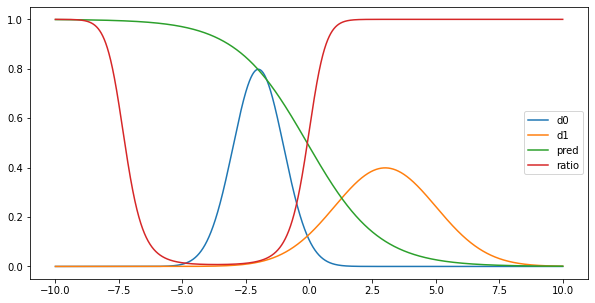

In [8]:
plt.figure(figsize=(10,5))
plt.plot(x_scale, d0_pdf*2, label='d0') # умножение на 2 для красоты графиков, на распределения не влияет
plt.plot(x_scale, d1_pdf*2, label='d1')
plt.plot(x_scale, dist.flatten(), label='pred')
plt.plot(x_scale, ratio, label='ratio')
plt.legend();

In [9]:
print([p.data[0] for p in layer.parameters()])

[tensor([-0.7069]), tensor(-0.0532)]


In [10]:
torch.log(F.sigmoid(torch.tensor(-100.)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(-inf)

In [11]:
F.logsigmoid(torch.tensor(-100.))

tensor(-100.)

### Homework

In [4]:
d2_0 = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([1., 1.]), torch.tensor([[1., 0], [0., 1]])) # делаем двумерные данные
d2_1 = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([-1., -1]), torch.tensor([[1., 0], [0., 1]]))
d2_0.sample((2,))

tensor([[2.1484, 0.2585],
        [0.6253, 1.3025]])

In [0]:
def sample(d2_0, d2_1, n=32*32):
    # из распределений набираем экземпляры обучающей выборки (n случайных элементов из каждого распределения)
    x0 = d2_0.sample((n,))
    x1 = d2_1.sample((n,))

    # добавляем правильные ответы. считаем что принадлежность к  
    y0 = torch.zeros((n, 1)) # d0 это класс 0
    y1 = torch.ones((n, 1))  # d1 это класс 1 

    # в результате надо вернуть два тензора. 
    # первый - со значениями функций
    # второй - "класс" функции которому принадлежит соответствующее значение
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [21]:
# Сделаем нейросетку из одного слоя и одного нейрона (2 вход и 1 выход)
# Applies a linear transformation to the incoming data: y = xA^T + b
layer = nn.Linear(2, 1)

# посмотрим на параметры и данные:
print(layer.parameters)
for p in layer.parameters():
    print(p.data)

# теперь как будем оптимизировать ошибку:
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

<bound method Module.parameters of Linear(in_features=2, out_features=1, bias=True)>
tensor([[-0.5825,  0.2659]])
tensor([-0.3357])


In [24]:
# начинаем обучение
log_freq = 500

# обучаем 10000 итераций
for i in range(10000):
    # проверяем качество раз в 500 итераций
    if i % log_freq == 0:
        # этот блок будет выполнен без подсчета градиентов вообще
        with torch.no_grad():
            # тестовой выборки у нас нет, но есть знания о распределениях
            # поэтому просто насемплируем новых данных, которых сеть не видела
            # и на которых не обучалась - будет эквивалент тестовой выборки
            x, y = sample(d2_0, d2_1, 10000)

            # тут два действия в одном - пропускаем через сумматор (layer)
            # и выходы сумматора пропускаем через функцию активации
            out = torch.sigmoid(layer(x))

            # в качестве метрики ошибки считаем бинарную кросс-энтропию между ответами сети 
            # и реальными значениями классов
            loss = F.binary_cross_entropy(out, y)
        print(f"Ошибка после {i} итераций: {round(loss.item(),4)}")

    # torch накапливает градиенты, поэтому принудительно перед их новым подсчетом обнуляем накопленные значений    
    layer_opt.zero_grad()

    # нужно относительно чего-то считать ошибку
    # вот по этим ответам и посчитаем:
    x, y = sample(d2_0, d2_1, 1024)
    out = torch.sigmoid(layer(x))

    # относительно полученного лосса и будем делать
    loss = F.binary_cross_entropy(out, y)

    # бэкпроп - считаем градиенты
    loss.backward()

    # обновляем веса по подсчитанным градиентам 
    layer_opt.step()

Ошибка после 0 итераций: 0.2011
Ошибка после 500 итераций: 0.1995
Ошибка после 1000 итераций: 0.1999
Ошибка после 1500 итераций: 0.1996
Ошибка после 2000 итераций: 0.2018
Ошибка после 2500 итераций: 0.1954
Ошибка после 3000 итераций: 0.1955
Ошибка после 3500 итераций: 0.1994
Ошибка после 4000 итераций: 0.1998
Ошибка после 4500 итераций: 0.1988
Ошибка после 5000 итераций: 0.1981
Ошибка после 5500 итераций: 0.2033
Ошибка после 6000 итераций: 0.1951
Ошибка после 6500 итераций: 0.1974
Ошибка после 7000 итераций: 0.19
Ошибка после 7500 итераций: 0.1942
Ошибка после 8000 итераций: 0.1944
Ошибка после 8500 итераций: 0.1971
Ошибка после 9000 итераций: 0.1912
Ошибка после 9500 итераций: 0.2021
